In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import KNNImputer

#model selection from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
#pca
from sklearn.decomposition import PCA
#data_balance
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [6]:
import os
os.chdir(r'C:\Users\VISHY\Desktop\Great Learning\Capstone\CAPSTONE\Data')

In [36]:
df = pd.read_csv('train.csv')

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [147]:
df

,disbursed_amount,asset_cost,ltv,manufacturer_id,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,45,01-01-84,Salaried,03-08-18,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,47145,65550,73.23,45,31-07-85,Self employed,26-09-18,1,0,0,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,53278,61360,89.63,45,24-08-85,Self employed,01-08-18,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,57513,66113,88.48,45,30-12-93,Self employed,26-10-18,1,0,0,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,52378,60300,88.39,45,09-12-77,Self employed,26-09-18,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,63213,105405,60.72,48,01-08-88,Salaried,26-10-18,0,0,1,...,0,0,4084,0,0,0,1yrs 9mon,3yrs 3mon,0,0
233150,73651,100600,74.95,51,05-12-88,Self employed,23-10-18,0,0,1,...,0,0,1565,0,0,0,0yrs 6mon,0yrs 6mon,0,0
233151,33484,71212,48.45,86,01-06-76,Salaried,24-10-18,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
233152,34259,73286,49.10,86,26-03-94,Salaried,29-09-18,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [38]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d1,d2

risk_map = {'No Bureau History Available':-1, 
              'Not Scored: No Activity seen on the customer (Inactive)':-1,
              'Not Scored: Sufficient History Not Available':-1,
              'Not Scored: No Updates available in last 36 months':-1,
              'Not Scored: Only a Guarantor':-1,
              'Not Scored: More than 50 active Accounts found':-1,
              'Not Scored: Not Enough Info available on the customer':-1,
              'Very Low Risk':4,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk'],df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'credit_risk_label'] = df['credit_risk'].apply(lambda x: risk_map[x])
df.loc[:,'credit_rate'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'employment_label'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk', 'credit_risk_grade','Employment.Type','credit_risk_label'],axis=1)

In [39]:
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], format = "%d-%m-%y",infer_datetime_format=True)
df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], format = "%d-%m-%y",infer_datetime_format=True)
now = pd.Timestamp('now')
df['Age'] = (now - df['Date.of.Birth']).astype('<m8[Y]').astype(int)
age_mean = int(df[df['Age']>0]['Age'].mean())
df.loc[:,'Age'] = df['Age'].apply(lambda x: x if x>0 else age_mean)
df['disbursal_months_passed'] = ((now - df['DisbursalDate'])/np.timedelta64(1,'M')).astype(int)
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(lambda x : int(re.findall(r'\d+',x)[0])*12 + int(re.findall(r'\d+',x)[1]))
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(lambda x : int(re.findall(r'\d+',x)[0])*12 + int(re.findall(r'\d+',x)[1]))

df.loc[:,'no_of_accts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']

df.loc[:,'pri_inactive_accts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'sec_inactive_accts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'tot_inactive_accts'] = df['pri_inactive_accts'] + df['sec_inactive_accts']
df.loc[:,'tot_overdue_accts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'tot_current_balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'tot_sanctioned_amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'tot_disbursed_amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'tot_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

In [40]:
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','pri_inactive_accts','sec_inactive_accts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [41]:
cols=['asset_cost','tot_current_balance','tot_sanctioned_amount','tot_disbursed_amount','tot_installment']

In [152]:
df.shape

(233154, 29)

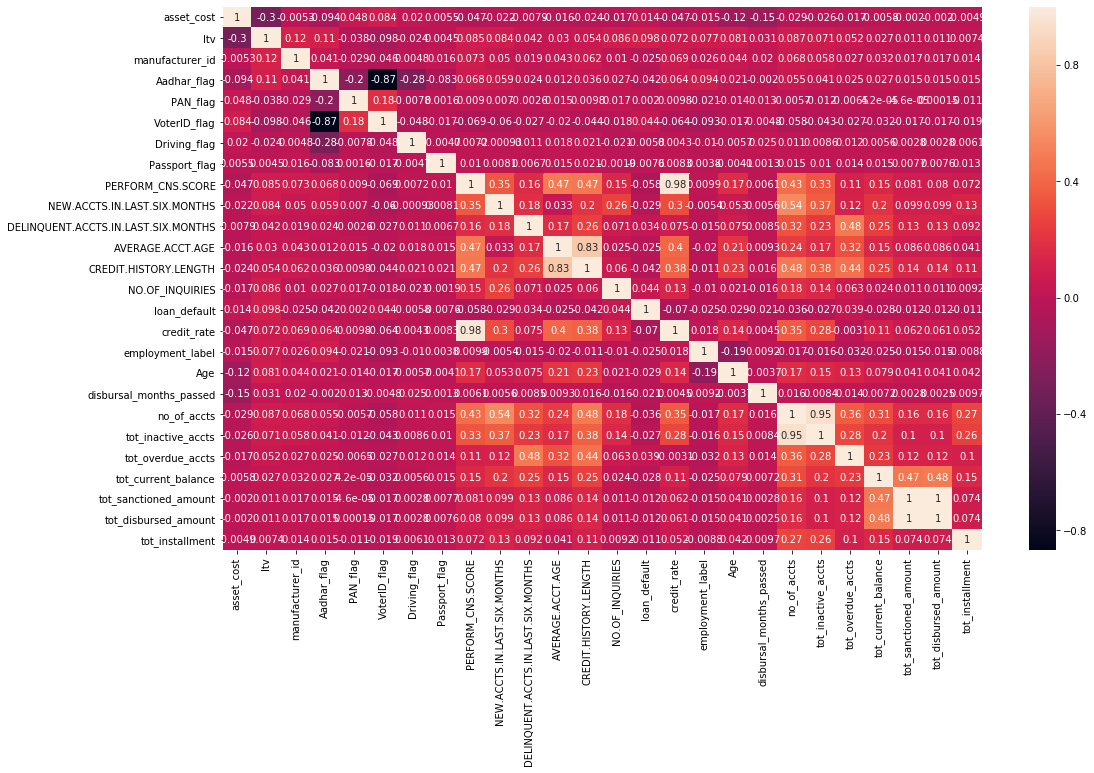

In [47]:
plt.figure(figsize=(17,10))
sns.heatmap(df.corr(),annot=True)

In [81]:
df

,disbursed_amount,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,employment_label,Age,disbursal_months_passed,no_of_accts,tot_inactive_accts,tot_overdue_accts,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment
0,50578,58400,89.55,45,1,0,0,0,0,0,...,1,36,17,0,0,0,0,0,0,0
1,47145,65550,73.23,45,1,0,0,0,0,598,...,0,34,15,1,0,1,27600,50200,50200,1991
2,53278,61360,89.63,45,1,0,0,0,0,0,...,0,34,17,0,0,0,0,0,0,0
3,57513,66113,88.48,45,1,0,0,0,0,305,...,0,26,14,3,3,0,0,0,0,31
4,52378,60300,88.39,45,1,0,0,0,0,0,...,0,42,15,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,63213,105405,60.72,48,0,0,1,0,0,735,...,1,31,14,4,1,0,390443,416133,416133,4084
233150,73651,100600,74.95,51,0,0,1,0,0,825,...,0,31,14,1,1,0,0,0,0,1565
233151,33484,71212,48.45,86,1,0,0,0,0,0,...,1,43,14,0,0,0,0,0,0,0
233152,34259,73286,49.10,86,1,0,0,0,0,0,...,1,25,15,0,0,0,0,0,0,0


In [88]:
q3=df['asset_cost'].quantile(0.75)
q1=df['asset_cost'].quantile(0.25)
iqr=q3-q1
df.loc[df['asset_cost'] > 350000,'asset_cost'].shape

(8,)

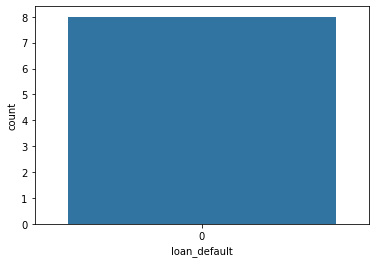

In [90]:
sns.countplot(df.loc[df['asset_cost'] > 350000,:]['loan_default'])

asset_cost


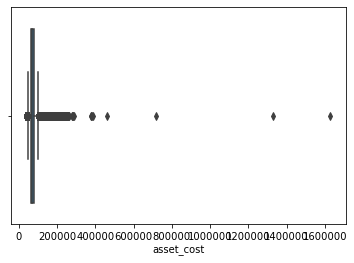

tot_current_balance


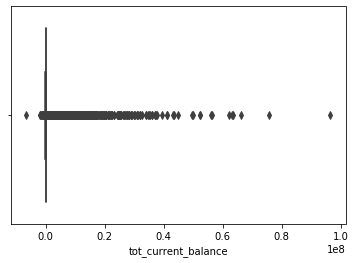

tot_sanctioned_amount


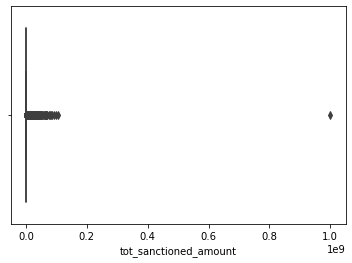

tot_disbursed_amount


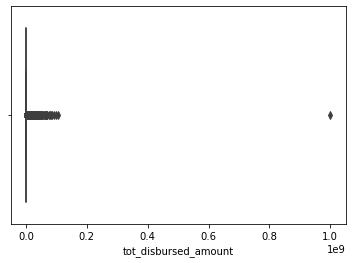

tot_installment


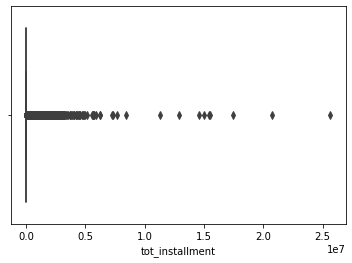

In [40]:
for i in cols:
    print(i)
    sns.boxplot(df[i])
    plt.show()

In [96]:
col,val=[],[]
for i in cols:
    q1=df[i].quantile(0.25)
    q3=df[i].quantile(0.75)
    iqr=q3-q1
    #print(i, q3+iqr)
    print(df.loc[df[i] > q3+iqr,i].count()/df[i].shape[0])

0.13695668956998377
0.19116120675604964
0.1877900443483706
0.18799162785111986
0.18556404779673522


In [132]:
q3=df['asset_cost'].quantile(0.75)
q1=df['asset_cost'].quantile(0.25)
iqr=q3-q1
df.loc[df['asset_cost'] > q3+iqr,'asset_cost'].shape

(31932,)

In [133]:
l1=set(df.loc[df['asset_cost'] > q3+iqr,'asset_cost'].index)

In [134]:
q3=df['tot_current_balance'].quantile(0.75)
q1=df['tot_current_balance'].quantile(0.25)
iqr=q3-q1
df.loc[df['tot_current_balance'] > q3+iqr,'tot_current_balance'].shape

(44570,)

In [135]:
l2=set(df.loc[df['tot_current_balance'] > q3+iqr,'tot_current_balance'].index)

In [136]:
lq3=df['tot_sanctioned_amount'].quantile(0.75)
q1=df['tot_sanctioned_amount'].quantile(0.25)
iqr=q3-q1
l3=set(df.loc[df['tot_sanctioned_amount'] > q3+iqr,'tot_sanctioned_amount'].index)

In [137]:
lq3=df['tot_disbursed_amount'].quantile(0.75)
q1=df['tot_disbursed_amount'].quantile(0.25)
iqr=q3-q1
l4=set(df.loc[df['tot_disbursed_amount'] > q3+iqr,'tot_disbursed_amount'].index)

In [138]:
lq3=df['tot_installment'].quantile(0.75)
q1=df['tot_installment'].quantile(0.25)
iqr=q3-q1
l5=set(df.loc[df['tot_installment'] > q3+iqr,'tot_installment'].index)

In [155]:
len(l1&l2&l3)

5107

In [143]:
df=df.drop(l1&l2&l3&l4&l5,axis=0)

In [144]:
df.shape

(232671, 29)

In [21]:
col,val=[],[]
for i in cols:
    q1=df[i].quantile(0.25)
    q3=df[i].quantile(0.75)
    iqr=q3-q1
    print(i, q3+iqr)
    df.loc[df[i] > q3+iqr,i] = np.nan

asset_cost 92686.5
tot_current_balance 74672.0
tot_sanctioned_amount 131299.5
tot_disbursed_amount 128568.0
tot_installment 4166.0


In [22]:
df.loc[df['tot_current_balance'] < q1-iqr,'tot_current_balance'] = np.nan

In [ ]:
df==np.nan

## Do the below graph after outlier treatment (above)

asset_cost


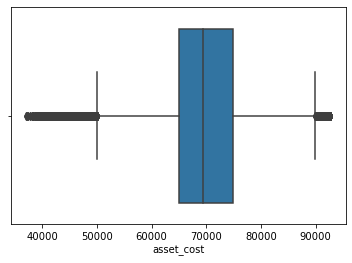

tot_current_balance


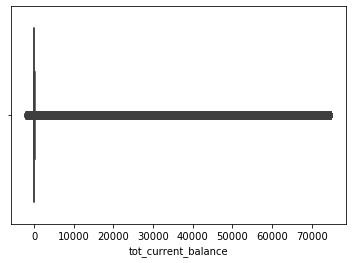

tot_sanctioned_amount


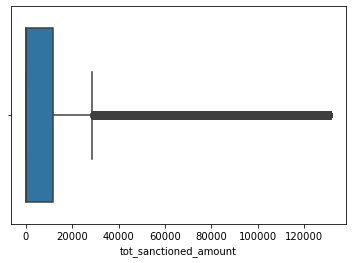

tot_disbursed_amount


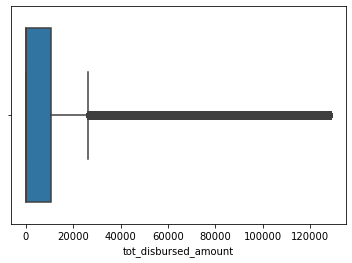

tot_installment


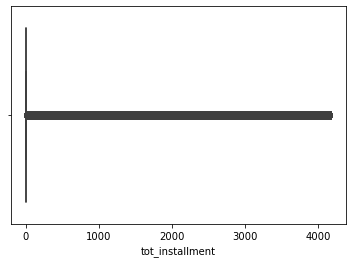

In [31]:
for i in cols:
    print(i)
    sns.boxplot(df[i])
    plt.show()

In [32]:
df.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'manufacturer_id',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag', 'PERFORM_CNS.SCORE', 'SEC.ACTIVE.ACCTS',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'credit_risk_label', 'sub_risk_label',
       'employment_label', 'Age', 'disbursal_months_passed', 'no_of_accts',
       'tot_inactive_accts', 'tot_overdue_accts', 'tot_current_balance',
       'tot_sanctioned_amount', 'tot_disbursed_amount', 'tot_installment'],
      dtype='object')

In [33]:
df=df.drop(['disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [23]:
x=df[cols].values

In [24]:
print(x)

[[58400.     0.     0.     0.     0.]
 [65550. 27600. 50200. 50200.  1991.]
 [61360.     0.     0.     0.     0.]
 ...
 [71212.     0.     0.     0.     0.]
 [73286.     0.     0.     0.     0.]
 [   nan     0.     0.     0.     0.]]


In [13]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=4)

In [25]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [26]:
imputer = IterativeImputer(missing_values=np.nan, random_state=0)

In [27]:
dff=imputer.fit_transform(x)

In [28]:
dff=pd.DataFrame(dff, columns=cols)

In [29]:
dff

,asset_cost,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment
0,58400.000000,0.000000,0.000000,0.000000,0.0
1,65550.000000,27600.000000,50200.000000,50200.000000,1991.0
2,61360.000000,0.000000,0.000000,0.000000,0.0
3,66113.000000,0.000000,0.000000,0.000000,31.0
4,60300.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...
233149,67892.435602,16085.638629,29404.108911,30602.022591,4084.0
233150,69302.853227,0.000000,0.000000,0.000000,1565.0
233151,71212.000000,0.000000,0.000000,0.000000,0.0
233152,73286.000000,0.000000,0.000000,0.000000,0.0


In [30]:
df=df.drop(cols,axis=1)

In [31]:
df=pd.concat([df,dff],axis=1)
df

,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,...,Age,disbursal_months_passed,no_of_accts,tot_inactive_accts,tot_overdue_accts,asset_cost,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment
0,89.55,45,1,0,0,0,0,0,0,0,...,36,17,0,0,0,58400.000000,0.000000,0.000000,0.000000,0.0
1,73.23,45,1,0,0,0,0,598,0,1,...,34,15,1,0,1,65550.000000,27600.000000,50200.000000,50200.000000,1991.0
2,89.63,45,1,0,0,0,0,0,0,0,...,34,17,0,0,0,61360.000000,0.000000,0.000000,0.000000,0.0
3,88.48,45,1,0,0,0,0,305,0,0,...,26,14,3,3,0,66113.000000,0.000000,0.000000,0.000000,31.0
4,88.39,45,1,0,0,0,0,0,0,0,...,42,15,0,0,0,60300.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,60.72,48,0,0,1,0,0,735,0,0,...,31,14,4,1,0,67892.435602,16085.638629,29404.108911,30602.022591,4084.0
233150,74.95,51,0,0,1,0,0,825,0,0,...,31,14,1,1,0,69302.853227,0.000000,0.000000,0.000000,1565.0
233151,48.45,86,1,0,0,0,0,0,0,0,...,43,14,0,0,0,71212.000000,0.000000,0.000000,0.000000,0.0
233152,49.10,86,1,0,0,0,0,0,0,0,...,25,15,0,0,0,73286.000000,0.000000,0.000000,0.000000,0.0


In [16]:
df

,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,Age,disbursal_months_passed,no_of_accts,tot_inactive_accts,tot_overdue_accts,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment,number_of_0
0,58400,89.55,45,1,0,0,0,0,0,0,...,36,17,0,0,0,0,0,0,0,18
1,65550,73.23,45,1,0,0,0,0,598,0,...,34,15,1,0,1,27600,50200,50200,1991,8
2,61360,89.63,45,1,0,0,0,0,0,0,...,34,17,0,0,0,0,0,0,0,19
3,66113,88.48,45,1,0,0,0,0,305,0,...,26,14,3,3,0,0,0,0,31,12
4,60300,88.39,45,1,0,0,0,0,0,0,...,42,15,0,0,0,0,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,105405,60.72,48,0,0,1,0,0,735,0,...,31,14,4,1,0,390443,416133,416133,4084,9
233150,100600,74.95,51,0,0,1,0,0,825,0,...,31,14,1,1,0,0,0,0,1565,13
233151,71212,48.45,86,1,0,0,0,0,0,0,...,43,14,0,0,0,0,0,0,0,18
233152,73286,49.10,86,1,0,0,0,0,0,0,...,25,15,0,0,0,0,0,0,0,18


In [42]:
pd.crosstab(df['credit_rate'],df['loan_default']).apply(lambda x: x/x.sum(), axis=1)

loan_default,0,1
credit_rate,,
-1,0.770274,0.229726
1,0.695419,0.304581
2,0.719577,0.280423
3,0.721880,0.278120
4,0.747599,0.252401
5,0.727371,0.272629
6,0.758133,0.241867
7,0.802909,0.197091
8,0.813789,0.186211


In [43]:
df.columns

Index(['ltv', 'manufacturer_id', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'credit_risk_label', 'sub_risk_label',
       'employment_label', 'Age', 'disbursal_months_passed', 'no_of_accts',
       'tot_inactive_accts', 'tot_overdue_accts', 'asset_cost',
       'tot_current_balance', 'tot_sanctioned_amount', 'tot_disbursed_amount',
       'tot_installment'],
      dtype='object')

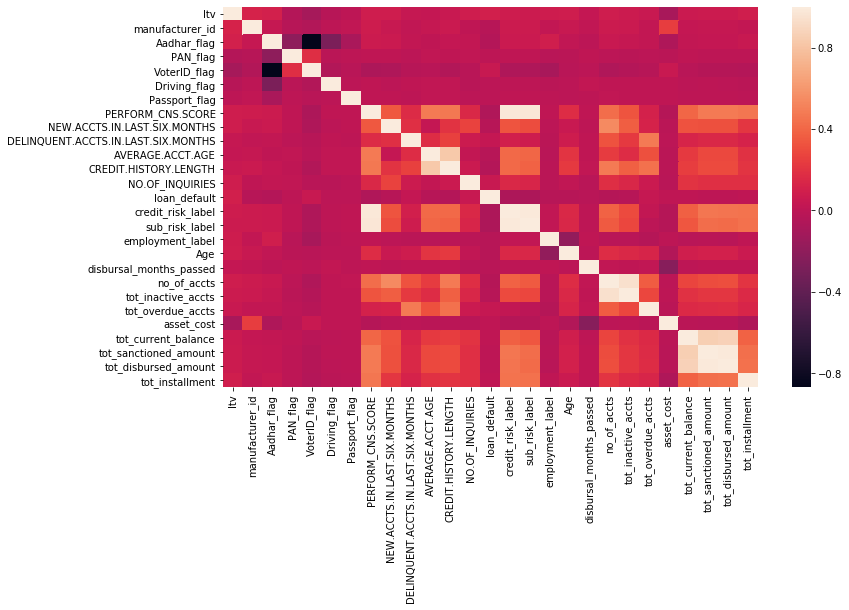

In [39]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr())

In [11]:
df[cols]

,asset_cost,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment
0,58400,0,0,0,0
1,65550,27600,50200,50200,1991
2,61360,0,0,0,0
3,66113,0,0,0,31
4,60300,0,0,0,0
...,...,...,...,...,...
233149,105405,390443,416133,416133,4084
233150,100600,0,0,0,1565
233151,71212,0,0,0,0
233152,73286,0,0,0,0


In [12]:
num_cols=['asset_cost','tot_current_balance','tot_sanctioned_amount','tot_disbursed_amount','tot_installment','PERFORM_CNS.SCORE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES']

In [13]:
df['number_of_0'] = (df == 0).astype(int).sum(axis=1)

In [15]:
df.head()

,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,Age,disbursal_months_passed,no_of_accts,tot_inactive_accts,tot_overdue_accts,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment,number_of_0
0,58400,89.55,45,1,0,0,0,0,0,0,...,36,17,0,0,0,0,0,0,0,18
1,65550,73.23,45,1,0,0,0,0,598,0,...,34,15,1,0,1,27600,50200,50200,1991,8
2,61360,89.63,45,1,0,0,0,0,0,0,...,34,17,0,0,0,0,0,0,0,19
3,66113,88.48,45,1,0,0,0,0,305,0,...,26,14,3,3,0,0,0,0,31,12
4,60300,88.39,45,1,0,0,0,0,0,0,...,42,15,0,0,0,0,0,0,0,17


In [14]:
df['number_of_0']

0         18
1          8
2         19
3         12
4         17
          ..
233149     9
233150    13
233151    18
233152    18
233153    18
Name: number_of_0, Length: 233154, dtype: int64

In [123]:
sc=StandardScaler()
dff=sc.fit_transform(df[num_cols])

In [124]:
dff=pd.DataFrame(dff, columns=num_cols)

In [125]:
df=df.drop(num_cols,axis=1)

In [126]:
dff

,asset_cost,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,-0.921895,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,-0.292450
1,-0.544482,-0.149597,-0.073657,-0.073337,-0.075084,0.911822,-0.399782,2.347632,0.932337,0.236085,-0.292450
2,-0.765651,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,-0.292450
3,-0.514764,-0.178324,-0.094714,-0.094368,-0.087951,0.045917,-0.399782,-0.253566,-0.060621,-0.043819,1.122986
4,-0.821604,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,1.122986
...,...,...,...,...,...,...,...,...,...,...,...
233149,1.559268,0.228063,0.079838,0.079974,-0.061344,1.316700,-0.399782,-0.253566,0.799942,0.795894,-0.292450
233150,1.305636,-0.178324,-0.094714,-0.094368,-0.077881,1.582678,-0.399782,-0.253566,-0.193015,-0.358712,-0.292450
233151,-0.245613,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,-0.292450
233152,-0.136136,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,-0.292450


In [127]:
df=pd.concat([df,dff],axis=1)

In [128]:
df

,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,loan_default,credit_risk_label,sub_risk_label,...,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,89.55,45,1,0,0,0,0,0,-1,-1,...,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,-0.292450
1,73.23,45,1,0,0,0,0,1,2,5,...,-0.149597,-0.073657,-0.073337,-0.075084,0.911822,-0.399782,2.347632,0.932337,0.236085,-0.292450
2,89.63,45,1,0,0,0,0,0,-1,-1,...,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,-0.292450
3,88.48,45,1,0,0,0,0,1,0,2,...,-0.178324,-0.094714,-0.094368,-0.087951,0.045917,-0.399782,-0.253566,-0.060621,-0.043819,1.122986
4,88.39,45,1,0,0,0,0,1,-1,-1,...,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,1.122986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,60.72,48,0,0,1,0,0,0,4,10,...,0.228063,0.079838,0.079974,-0.061344,1.316700,-0.399782,-0.253566,0.799942,0.795894,-0.292450
233150,74.95,51,0,0,1,0,0,0,4,13,...,-0.178324,-0.094714,-0.094368,-0.077881,1.582678,-0.399782,-0.253566,-0.193015,-0.358712,-0.292450
233151,48.45,86,1,0,0,0,0,0,-1,-1,...,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,-0.292450
233152,49.10,86,1,0,0,0,0,0,-1,-1,...,-0.178324,-0.094714,-0.094368,-0.088154,-0.855453,-0.399782,-0.253566,-0.590198,-0.568640,-0.292450


In [109]:
for i in num_cols:
    print(i, df.loc[df[i]>3,i].shape)

asset_cost (0,)
tot_current_balance (0,)
tot_sanctioned_amount (0,)
tot_disbursed_amount (0,)
tot_installment (0,)
PERFORM_CNS.SCORE (0,)
NEW.ACCTS.IN.LAST.SIX.MONTHS (3515,)
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS (2641,)
AVERAGE.ACCT.AGE (4457,)
CREDIT.HISTORY.LENGTH (5296,)
NO.OF_INQUIRIES (3357,)


In [129]:
for i in cols:
    df=df[df[i] < 2]
    df=df[df[i] > -2]

asset_cost


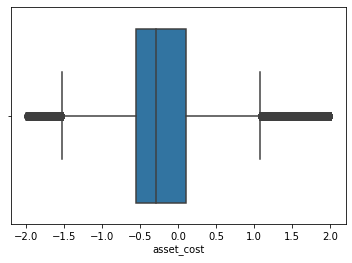

tot_current_balance


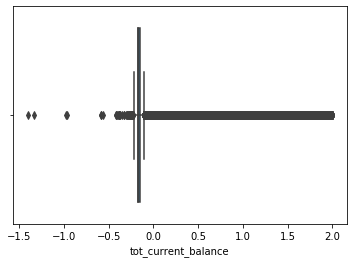

tot_sanctioned_amount


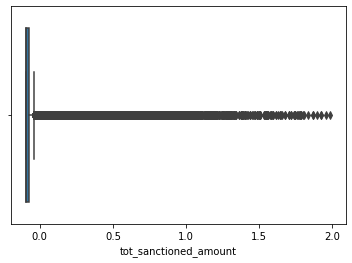

tot_disbursed_amount


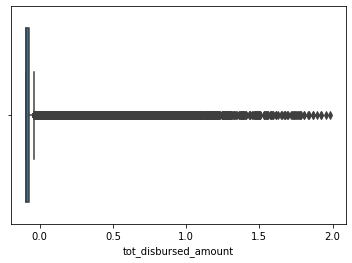

tot_installment


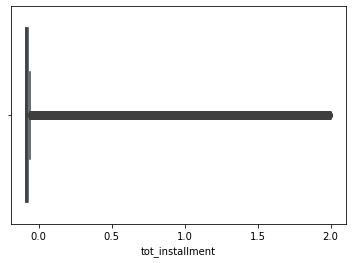

In [130]:
for i in cols:
    print(i)
    sns.boxplot(df[i])
    plt.show()

In [10]:
from scipy.stats import ttest_ind

In [11]:
ncols=['no_of_accts',
       'tot_inactive_accts', 'tot_overdue_accts', 'tot_current_balance',
       'tot_sanctioned_amount', 'tot_disbursed_amount', 'tot_installment']

In [12]:
k=0
cols=[]
for i in ncols:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    t,p=ttest_ind(df1[i],df2[i])
    print('T Test p Value for column ',i,': ',p)

T Test p Value for column  no_of_accts :  1.3735651659228895e-67
T Test p Value for column  tot_inactive_accts :  9.920485914288681e-39
T Test p Value for column  tot_overdue_accts :  4.892661813938949e-81
T Test p Value for column  tot_current_balance :  3.3079399073944727e-41
T Test p Value for column  tot_sanctioned_amount :  1.4009500779317766e-08
T Test p Value for column  tot_disbursed_amount :  2.1824831031189564e-08
T Test p Value for column  tot_installment :  2.341328916223375e-07


In [31]:
df.columns

Index(['asset_cost', 'ltv', 'manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'credit_risk_label', 'sub_risk_label',
       'employment_label', 'Age', 'disbursal_months_passed', 'no_of_accts',
       'tot_inactive_accts', 'tot_overdue_accts', 'tot_current_balance',
       'tot_sanctioned_amount', 'tot_disbursed_amount', 'tot_installment'],
      dtype='object')

In [32]:
df['manufacturer_id'].value_counts()

86     109534
45      56626
51      27204
48      16710
49      10220
120      9658
67       2405
145       778
153        12
152         6
156         1
Name: manufacturer_id, dtype: int64

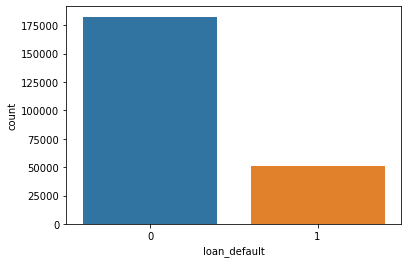

In [14]:
sns.countplot(df['loan_default'])